In [71]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using Ipopt
using MathOptInterface
using StaticArrays
const MOI = MathOptInterface;
using TrajectoryOptimization
using Altro
using RobotDynamics
# Meshcat Stuff
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\Research notes\Hybrid Altro\Project.toml`


In [7]:
# Dead simple hopper
function ez_dynamics(x, u)
    # x is a 4d vec, u is a 2d vec
    mh = 1.0
    mf = 1.0
    g = 9.81
    v = x[3:4]
    FLeg = u[1]
    FCon = u[2]
    xdd = [v; FLeg / mh - g; (FCon - FLeg)/mh - g]
end

function ez_dynamics_rk4(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = ez_dynamics(x, u)
    f2 = ez_dynamics(x + 0.5*h*f1, u)
    f3 = ez_dynamics(x + 0.5*h*f2, u)
    f4 = ez_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

function jump_map(x)
    #Assume the foot experiences inelastic collisions
    xn = [x[1:2]; 0.0; 0.0]
    return xn
end

struct Hoppity <: AbstractModel end
RobotDynamics.state_dim(::Hoppity) = 4
RobotDynamics.control_dim(::Hoppity) = 2

function RobotDynamics.dynamics(::Hoppity,x,u)
    ẋ = ez_dynamics(x, u)
end


In [54]:
n = 4
m = 2
N = 11
h = 0.1
modeSteps = 5
modeList = zeros(N)

iState = 1
next = 1
for i = 1:N
    modeList[i] = iState
    if mod(i, modeSteps) == 0
        iState += next
        next *= -1
    end
end

# c_init_inds = 1:n
#c_term_inds = c_init_inds[end]+1:c_init_inds[end]+n
c_term_inds = 1:n
c_head_inds = c_term_inds[end]+1:c_term_inds[end]+n
c_dyn_inds = c_head_inds[end]+1:c_head_inds[end]+n*(N-1)
c_stnc_inds = c_dyn_inds[end]+1:c_dyn_inds[end]+N
# c_length_inds = c_stnc_inds[end]+1:c_stnc_inds[end]+N

49:59

## Simple hopper reference traj

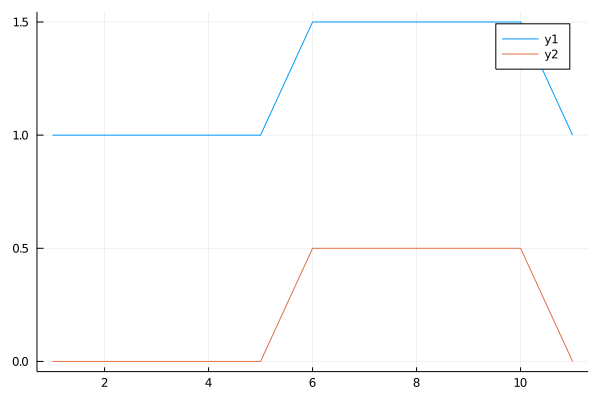

In [55]:
xRefSimp = zeros(n, N)
xRefSimp[1, :] .= 1.0
uRefSimp = zeros(m, N-1)

for i = 1:N
    if modeList[i] == 2
        xRefSimp[1, i] = 1.5
        xRefSimp[2, i] = 0.5
    end
end

xRefSimp[:, end] .= xRefSimp[:, 1]

plot(xRefSimp[1, :])
plot!(xRefSimp[2, :])

In [56]:
# Cost weights
Q = 1000.0*[1.0 0.0 0.0 0.0;
            0.0 1.0 0.0 0.0;
            0.0 0.0 1.0 0.0;
            0.0 0.0 0.0 1.0]
    
Qf = 10.0*[1.0 0.0 0.0 0.0;
            0.0 1.0 0.0 0.0;
            0.0 0.0 1.0 0.0;
            0.0 0.0 0.0 1.0]

R = 0.1*[1.0 0.0;
         0.0 1.0]

ueq = [9.81; 9.81*2]
XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
URefSimp = [SVector{m}(ueq) for i = 1:N-1]

10-element Array{SArray{Tuple{2},Float64,1,2},1}:
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]
 [9.81, 19.62]

In [ ]:
println(ez_dynamics_rk4([1.0, 0.0, 0.0, 0.0], [-2.0, 9.81-2.0], 0.1))

In [57]:
xLen = 4
uLen = 2
zLen = xLen + uLen

function unpack(Z)
    xinds = [((i-1)*(zLen) .+ (1:xLen)) for i=1:N]
    uinds = [((i-1)*(zLen) .+ ((xLen+1):zLen)) for i=1:N-1]
    X = [Z[inds] for inds in xinds]
    U = [Z[inds] for inds in uinds]
    return X, U
end

function pack(X, U)
    xinds = [(1 + (i-1)*zLen):(xLen + (i-1)*zLen) for i=1:N]
    uinds = [(xLen+1 + (i-1)*zLen):(xLen + uLen + (i-1)*zLen) for i=1:N-1]
    Z = zeros(N*xLen + (N-1)*uLen)
    for k = 1:N-1
        Z[xinds[k]] = X[k]
        Z[uinds[k]] = U[k]
    end
    Z[xinds[end]] = X[end]
    return Z
end

# ZRefSimp = pack(XRefSimp, URefSimp)
# println(ZRefSimp)
# println(unpack(ZRefSimp))
# println(modeList)

pack (generic function with 1 method)

In [58]:
function cost(Z)
    X, U = unpack(Z)
    J = 0.0
    for k = 1:N-1
        J += 0.5*(X[k] - XRefSimp[k])' * Q * (X[k] - XRefSimp[k]) + 0.5 * (U[k] - ueq)' * R * (U[k] - ueq)
    end
    J += 0.5*(X[end] - XRefSimp[end])' * Qf * (X[end] - XRefSimp[end])
    return J
end
        

cost (generic function with 1 method)

In [59]:
function dynamics_constraint!(c, Z)
    X, U = unpack(Z)
    d = reshape(view(c, c_dyn_inds), n, N-1)
    for i = 1:N-1
        d[:, i] = ez_dynamics_rk4(X[i], U[i], h) .- X[i+1]
    end
    return nothing
end

dynamics_constraint! (generic function with 1 method)

In [60]:
function head_constraint!(c, Z)
    X, U = unpack(Z)
    hd = view(c, c_dyn_inds)
    for i = 1:mSteps
        xStep = X[i]
        hd[i] = xStep[1] - 1.0
    end
    return nothing
end

head_constraint! (generic function with 1 method)

In [61]:
function stance_constraint!(c, Z)
    X, U = unpack(Z)
    s = view(c, c_stnc_inds)
    for i = 1:N
        # xStep, uStep = X[i], U[i]
        if modeList[i] == 1
            xStep = X[i]
            s[i] = xStep[2]
        else
            uStep = U[i]
            s[i] = uStep[2]
        end
    end
    return nothing
end

stance_constraint! (generic function with 1 method)

In [ ]:
function length_constraint!(c, Z)
    X, U = unpack(Z)
    l = view(c, c_length_inds)
    for i = 1:N
        xStep = X[i]
        l[i] = norm(xStep[1] - xStep[2])
    end
    return nothing
end

In [62]:
function con!(c,ztraj)
    # c[c_init_inds] .= ztraj[1:n] .- XRefSimp[1]
    c[c_term_inds] .= ztraj[1:n] .- XRefSimp[1] #terminal state constraint
    @views head_constraint!(c, ztraj)
    @views dynamics_constraint!(c,ztraj)
    @views stance_constraint!(c,ztraj)
    # @views length_constraint!(c,ztraj)
end

con! (generic function with 1 method)

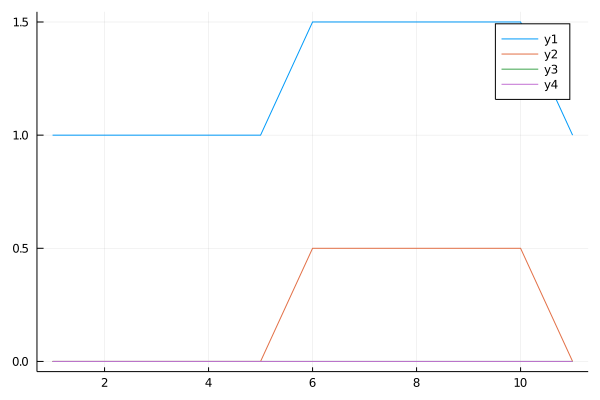

In [63]:
#Guess
Z0 = pack(XRefSimp, URefSimp)
plot(XRefSimp)

In [66]:
begin
    cinds = [c_term_inds, c_dyn_inds, c_stnc_inds]
    ourC = zeros(cinds[end][end])
    xg, ug = unpack(Z0)
    con!(ourC, Z0)
    println(ourC)
end

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.62, 19.62, 19.62, 19.62, 19.62, 0.0]


In [74]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=c_length_inds,
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    # c_l[idx_ineq] .= 0.5

    c_u = zeros(m)
    # c_u[idx_ineq] .= 1.5
    return c_l, c_u
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end


function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end


function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-2,c_tol=1.0e-2,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

In [86]:
# Dircol version
c_length_inds = 1:2
prob = ProblemMOI(n*N + m*(N-1), c_stnc_inds[end])
z_sol = solve(Z0,prob) # solve

LoadError: BoundsError: attempt to access 64-element Array{Float64,1} at index [65]

In [76]:
function toMatrix(arr)
    rows = length(arr)
    cols = length(arr[1])
    
    newArr = zeros(rows, cols)
    for i = 1:rows
        newArr[i, :] = arr[i]
    end
    return newArr
end

toMatrix (generic function with 1 method)

In [77]:
x_sol, u_sol = unpack(z_sol)
println(x_sol)
x_arr= toMatrix(x_sol)
u_arr = toMatrix(u_sol)

[[1.000000000001728, 6.831735126458006e-11, 3.781245493031918e-12, 8.679228753919573e-12], [1.0054428206164026, -2.2785637735467214e-10, 0.10885641225875693, -8.669832108246043e-9], [1.0164876422035263, 1.428331509183189e-10, 0.11204001945261126, 1.791219403626649e-8], [1.0278563002615735, -7.617897738917053e-11, 0.11533314168586248, -2.332568919638535e-8], [1.042346428860542, 2.4602752452435596e-11, 0.17446943027147993, 2.5834107130899558e-8], [1.1512975538584505, 0.10674380633296135, 2.0045530696702922, 2.1348761003337904], [1.3034945995879905, 0.27038967760474203, 1.0393878449048244, 1.1380413251025443], [1.3584574639030893, 0.33506973029113346, 0.05986944138440815, 0.15555972862536668], [1.3154399189590942, 0.30153019223662064, -0.920220340274426, -0.8263504897142405], [1.1740975073713353, 0.17011552082570955, -1.9066278914868464, -1.8019429385010715], [0.8752559451978805, 1.7145688264876098e-13, -4.070203351981658, -1.6003674780062975]]


10×2 Array{Float64,2}:
  10.8986      20.7086
   9.84184     19.6518
   9.84293     19.6529
  10.4014      20.2114
  28.1108      59.2696
   0.158348     1.74368e-13
   0.014816     7.75537e-14
   0.00910218   6.6401e-14
  -0.0540755    1.19635e-13
 -11.8258      -4.52683e-15

In [85]:
println(u_arr[:, 1:2])
plot(x_arr[:, 1])
trajXSolve = [SVector{4}(x_arr[i, :]) for i = 1:N]
visualize!(vis, trajXSolve, h)
plot!(x_arr[:, 2])
# Xref, uref = unpack(Z0)
# println(Z0)
# plot!(Xref, inds=1:2)
# println(Xref)
# plot!(u_arr[:, 1])
# plot!(u_arr[:, 2])

[10.898564122513672 20.7085640357784; 9.84183607194776 19.651836337726643; 9.842931222302004 19.652930809933405; 10.40136288585263 20.21136337743626; 28.110836393960874 59.2695971389434; 0.15834775233004533 1.7436788373578844e-13; 0.014815964779590985 7.755374562193668e-14; 0.009102183402796223 6.640096240495395e-14; -0.054075512119565856 1.1963508450250978e-13; -11.825754604948111 -4.52682701767637e-15]


LoadError: BoundsError: attempt to access 11×4 Array{Float64,2} at index [12, 1:4]

## This one is for the hopper dynamics I solved for, the dead simple one

[1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0]

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 19
    Solve Time: 440.836499 (ms)

  Covergence
    Terminal Cost: 22247.448455199414
    Terminal dJ: -0.00066587574838195
    Terminal gradient: 204.76212865724779
    Terminal constraint violation: 1.5497785735316054e-6
    Solve Status: SOLVE_SUCCEEDED


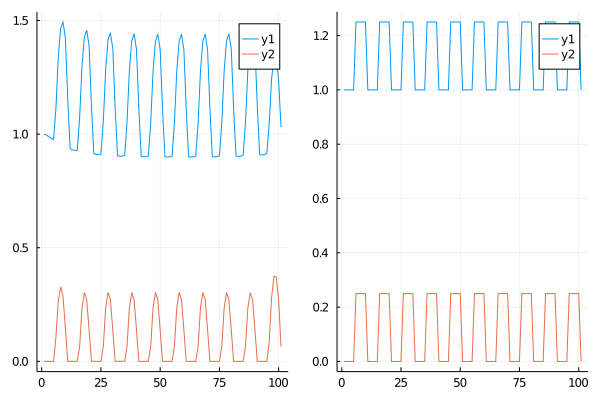

In [84]:
begin
    n = 4
    m = 2
    N = 101
    mSteps = 5
    
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    println(modeList)
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    A2[1, 2] = 1.0
    b2 = SVector{1}([0.0])
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
    A3 = zeros(1, m)
    A3[1, 2] = 1.0
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 1000.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 100.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.1*[1.0 0.0;
             0.0 1.0]
    
    # Duck down and jump up
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 2:N
        # println(-0.5*sin((i-1) * pi/3) + 1.0)
        if modeList[i] == 1
            xRefSimp[1, i] = 1.0
            xRefSimp[2, i] = 0.0
        else
            xRefSimp[1, i] = 1.25
            xRefSimp[2, i] = 0.25
        end
        # xRefSimp[2, i] = max(0.0, -0.5*sin((i-1) * pi/(mSteps)))
    end

    xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
   # println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
    # println(solveU)
end
    

## Bobbing


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 3
    Solve Time: 5.938899999999999 (ms)

  Covergence
    Terminal Cost: 4.944627260614441
    Terminal dJ: -3.6252567703343175e-7
    Terminal gradient: 1.350890839592332e-5
    Terminal constraint violation: 4.7656687197174035e-7
    Solve Status: SOLVE_SUCCEEDED
SArray{Tuple{2},Float64,1,2}[[9.90329468033197, 19.72024919782259], [10.718470749134097, 20.52326160565224], [10.938413236393343, 20.744564049484968], [10.724407085076187, 20.531331998568717], [10.162655523018282, 19.97146766543577], [9.468146995944597, 19.27929355651241], [8.906512731086634, 18.719549151560873], [8.692653983998042, 18.506409980640047], [8.908663042195593, 18.72169206647144], [9.472471399047157, 19.283603102659125], [10.169201880813894, 19.977991874522427], [10.733249944590698, 20.540146595423856], [10.949745381388633, 

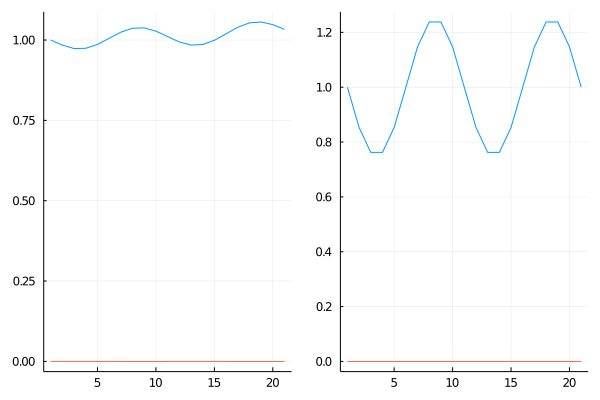

In [46]:
# Bobbing head up and down
begin
    n = 4
    m = 2
    N = 21
    mSteps = 5
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    modeSteps = 5
    modeList = zeros(N)

    iState = 1
    next = 1
    for i = 1:N
        modeList[i] = iState
        if mod(i, modeSteps) == 0
            iState += next
            next *= -1
        end
    end
    
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 1:N
#         if modeList[i] == 2
#             xRefSimp[1, i] = 1.25
#             xRefSimp[2, i] = 0.0
#         end
        xRefSimp[1, i] = 1.0 - 0.25*sin(pi/modeSteps*(i-1))
        xRefSimp[3, i] = -0.25*cos(pi/modeSteps*(i-1)) * pi/modeSteps
    end

    xRefSimp[:, end] .= xRefSimp[:, 1]

    plot(xRefSimp[1, :])
    plot!(xRefSimp[2, :])
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    # A2[1, 1] = 1.0
    A2[1, 2] = 1.0
    b2 = SVector{1}([0.0])
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
#     A3 = zeros(1, m)
#     A3[1, 2] = 1.0
#     b3 = SVector{1}(0.0)
#     flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
#         else
#             add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 100.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 10.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.01*[1.0 0.0;
             0.0 1.0]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], URefSimp[i]) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2), legend=false)
end
    
    
    

## Retracting

[1.0 1.0 1.0 1.0 1.0]

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 11
    Solve Time: 8.556799999999999 (ms)

  Covergence
    Terminal Cost: 27.400214799187335
    Terminal dJ: 0.005519178384741252
    Terminal gradient: 0.035170487267229225
    Terminal constraint violation: 3.0213618746645354e-9
    Solve Status: SOLVE_SUCCEEDED
SArray{Tuple{2},Float64,1,2}[[0.47132482174876933, 10.348612382190522], [6.905080972121595, 16.406199283583053], [12.468968694203797, 22.86917728790257], [19.19216414766096, 28.580785853173495]]


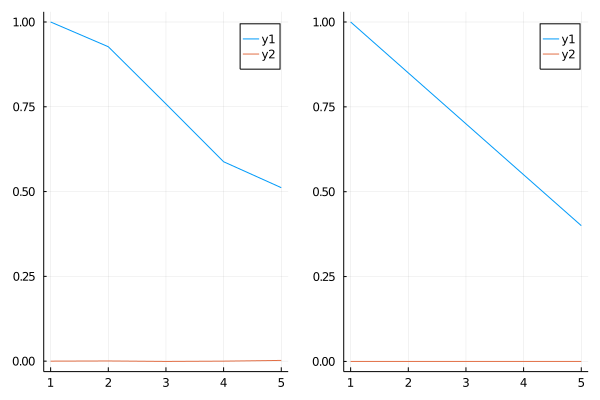

In [45]:
# Several Hops
begin
    n = 4
    m = 2
    N = 5
    mSteps = N
    
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    println(modeList)
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    A2[1, 2] = 1.0
    b2 = SVector{1}([0.0])
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
    A3 = zeros(1, m)
    A3[1, 2] = 1.0
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 1.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 100.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.1*[1.0 0.0;
             0.0 1.0]
    
    # Duck down and jump up
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 2:N
        # println(-0.5*sin((i-1) * pi/3) + 1.0)
        xRefSimp[1, i] = xRefSimp[1, i-1] - 0.75 / N
        # xRefSimp[2, i] = 0.5
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
end

## Several hops with shortening distance

[1.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 2.0 2.0 1.0]

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 13
    Solve Time: 24.6758 (ms)

  Covergence
    Terminal Cost: 188.89264406923155
    Terminal dJ: 0.0542032259206735
    Terminal gradient: 7.710210952429259
    Terminal constraint violation: 2.8566168999615894e-7
    Solve Status: SOLVE_SUCCEEDED
SArray{Tuple{2},Float64,1,2}[[8.563104981114739, 18.294104312718204], [9.621515458888608, 19.735884900750495], [10.289437196732978, 19.476948236631443], [12.821428663789971, 23.530295272789527], [24.663177329356277, 55.13461772487594], [1.067126527762229, 0.00014794663651483756], [0.1744977462310922, -0.0001505701765860553], [0.15807101121757952, -0.000186285877139955], [0.27628474047347973, -0.00017210487981389314], [2.989104662581785, -2.956205531671278e-14]]


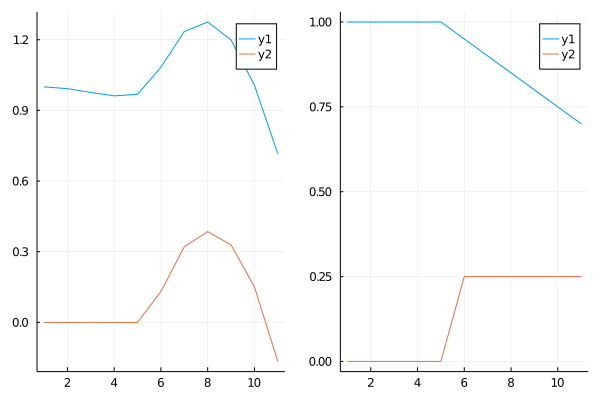

In [90]:
# Several Hops
begin
    n = 4
    m = 2
    N = 11
    mSteps = 5
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    println(modeList)
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    # A2[1, 1] = 1.0
    A2[1, 2] = 1.0
    b2 = SVector{1}(0.0)
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
    A3 = zeros(1, m)
    A3[1, 2] = 1.0
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 100.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 1.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.1*[1.0 0.0;
             0.0 1.0]
    
    # Duck down and jump up
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 2:N
        # println(-0.5*sin((i-1) * pi/3) + 1.0)
        if modeList[i] == 1 && i != N
            xRefSimp[1, i] = 1.0
            xRefSimp[2, i] = 0.0
            # xRefSimp[3, i] = 0.25 / mSteps
            # xRefSimp[4, i] = - 0.25 / mSteps
        else
            xRefSimp[1, i] = xRefSimp[1, i-1] - (0.25 / mSteps)
            xRefSimp[2, i] = 0.25
            xRefSimp[3, i] = - 0.25 / mSteps
            xRefSimp[4, i] = 0.25 / mSteps
        end
        # xRefSimp[2, i] = 0.5
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
   
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
end
    
    

## Varying Height Hops

In [92]:
# Several Varying Height Hops
begin
    n = 4
    m = 2
    N = 46
    mSteps = 11
    
    iState = 1
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            # next *= -1
        end
    end
    modeList[21] = 1.0
    modeList[22] = 1.0
    modeList[32] = 3.0
    modeList[33] = 1.0
    modeList[34] = 1.0
    modeList[45] = 4.0
    modeList[46] = 1.0
    
    
    x = zeros(n)
    g = 9.81
    ueq = [g, 2*g]
    model = Hoppity()
    
    
    conSet = ConstraintList(n, m, N)
    h = 0.1
    
    # The constraints we want are: 
    # 1) don't let the foot and head get too far away for all timesteps (Linear Constraint)
    # 2) in stance, set the foot height to be 0 (Linear Constraint)
    # 3) in flight, set the control height to be 0 (Linear Constraint)
    
#     # At all times
#     A1 = zeros(1, n)
#     A1[1, 1] = -1.0
#     A1[1, 2] = 1.0
#     b1 = SVector{1}(0.0)
#     cont = LinearConstraint(n, m, A1, b1, Inequality(), 1:n)
#     add_constraint!(conSet, cont, 1:N-1)
#     # add_constraint!(conSet, stnc, N)
    
    # Stance ones
    A2 = zeros(1, n)
    # A2[1, 1] = 1.0
    A2[1, 2] = 1.0
    b2 = SVector{1}(0.0)
    stnc = LinearConstraint(n, m, A2, b2, Equality(), 1:n)
    
#     # add_constraint!(conSet, stnc, N)
    
    # Flight ones
    A3 = zeros(1, m)
    A3[1, 2] = 1.0
    b3 = SVector{1}(0.0)
    flgt = LinearConstraint(n, m, A3, b3, Equality(), (n+1):(n+m))
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
        
    
    Q = 1000.0 * [1.0 0.0 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    Qf = 100.0*[1.0 0.0 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 0.0;
                0.0 0.0 0.0 1.0]
    
    # intln(typeof())
    R = 0.01*[1.0 0.0;
             0.0 1.0]
    
    # Duck down and jump up
    xRefSimp = zeros(n, N)
    xRefSimp[1, :] .= 1.0
    uRefSimp = zeros(m, N-1)
    for i = 2:N
        # println(-0.5*sin((i-1) * pi/3) + 1.0)
        cmode = modeList[i]
        if cmode == 1
            xRefSimp[1, i] = 1.0
            xRefSimp[2, i] = 0.0
        else
            if cmode == 2
                xRefSimp[1, i] = 2.0
                xRefSimp[2, i] = 1.0
            elseif cmode == 3
                xRefSimp[1, i] = 2.5
                xRefSimp[2, i] = 1.5
            else
                xRefSimp[1, i] = 3.0
                xRefSimp[2, i] = 2.0
            end
        end
    end

    xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    prob_hop = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob_hop, URefSimp[1])
    rollout!(prob_hop)
    
#     opts = SolverOptions(
#     cost_tolerance_intermediate=1e-2,
#     penalty_scaling=10.,
#     penalty_initial=1.0
#     )
    
    solver = ALTROSolver(prob_hop)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
   # println(solveU)
    
    p1 = plot(solveX, inds=1:2)
    p2 = plot(XRefSimp, inds=1:2)
    plot(p1, p2, layout = (1, 2), legend=false)
    visualize!(vis, solveX, h)
end


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 17
    Solve Time: 65.997599 (ms)

  Covergence
    Terminal Cost: 37262.887277625
    Terminal dJ: 0.5328567020624178
    Terminal gradient: 510.96130372563925
    Terminal constraint violation: 6.519472674299117e-7
    Solve Status: SOLVE_SUCCEEDED


## Visualizer Code

In [47]:
function kinematics(x)
    return [x[1], x[2]]
end

function visualize!(vis, Xs, h)
    r_body = 0.2
    r_foot = 0.1
    r_leg = 0.5*r_foot
    
    setvisible!(vis["/Background"], true)
    headSphere = Sphere(Point3f0(0), convert(Float32, r_body))
    footSphere = Sphere(Point3f0(0), convert(Float32, r_foot))
    legSphere = Sphere(Point3f0(0), convert(Float32, r_leg))
    setobject!(vis["body"], headSphere, MeshPhongMaterial(color = RGBA(1.0, 0.0, 1.0, 1.0)))
    setobject!(vis["foot"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    
    n_leg = 100
    for i = 1:n_leg
        setobject!(vis["leg$i"], legSphere, MeshPhongMaterial(color=RGBA(0.0, 0.0, 0.0, 1.0)))
    end
    
    p_leg = [zeros(3) for i = 1:n_leg]
    
    anim = MeshCat.Animation(convert(Int, floor(1.0 / h)))
    
    for t = 1:length(Xs)
        x = Xs[t]
        p_body = [0.0, 0.0, x[1]]
        p_foot = [0.0, 0.0, x[2]]
        zDist = x[1] - x[2]
        
        z_shift = [0.0, 0.0, r_foot]
        
        for i = 1:n_leg
            p_leg[i] .= [0.0, 0.0, zDist/n_leg*i + x[2]]
        end
        
        
        
        MeshCat.atframe(anim, t) do 
            settransform!(vis["body"], Translation(p_body + z_shift))
            settransform!(vis["foot"], Translation(p_foot + z_shift))
            
            for i = 1:n_leg
                settransform!(vis["leg$i"], Translation(p_leg[i] + z_shift))
            end
        end
    end
    MeshCat.setanimation!(vis, anim)
end
            

visualize! (generic function with 1 method)

In [5]:
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))